In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def obj_func(m, index):
    u, s, vh = np.linalg.svd(m)

    return s[index]

def obj_func_nuc(m, index):
    u, s, vh = np.linalg.svd(m)

    return np.sum(s)

def comp_grad(m, obj_func, index):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-3

    # Yes, grad is a vector now
    grad = []

    for i in range(2):
        for j in range(2):
            diff = np.zeros([2,2])
            diff[i,j] = epsilon
            grad.append((obj_func(m + diff, index) - obj_func(m - diff, index))/(2*epsilon))

    return grad

In [17]:
M = np.array([[1, 0],
              [0, 0]])

vectors = np.zeros([2, 4])

for index in range(2):
    print(index)
    vectors[index,:] = np.array(comp_grad(M, obj_func, index))
    
vectors

0
1


array([[1., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [18]:
np.array(comp_grad(M, obj_func_nuc, 1))

array([1., 0., 0., 0.])

From this, the first order descent cone is $x_{11} \leq 0$

To get second order descent cone, need to compute Hessian:

In [19]:
def comp_hessian(m, of):
    """ Computes hessian (only diagonal) """
    vector = []
    
    n = 2

    for i in range(n):
        for j in range(n):
            vector.append(m[i,j])

    q = len(vector)

    epsilon = 1e-3
    hessian = np.zeros([q, q])

    # fill in the diagonal first
    count = 0
    for i in range(n):
        for j in range(n):
            diff = np.zeros([n,n])
            diff[i,j] = epsilon
            hessian[count,count] = (of(m + diff, index) + of(m - diff, index) - 2*of(m, index))/epsilon**2

            count = count + 1
                
    # now fill in off-diagonals
    count1 = 0
    for i1 in range(n):
        for j1 in range(n):
            diff1 = np.zeros([n,n])
            diff1[i1,j1] = epsilon

            count2 = 0
            for i2 in range(n):
                for j2 in range(n):
                    diff2 = np.zeros([n,n])
                    diff2[i2,j2] = epsilon

                    if count1 != count2: # doing only off-diagonal ones
                        hessian[count1,count2] = (of(m + diff1 + diff2, index) + of(m - diff1 - diff2, index)
                                                 - of(m + diff1 - diff2, index) - of(m - diff1 + diff2, index))/(2*epsilon)**2

                    count2 = count2 + 1

            count1 = count1 + 1

    return hessian

In [26]:
comp_hessian(M, obj_func_nuc)

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 9.9999975e-01, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 9.9999975e-01, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.0000000e+03]])

In [29]:
H = comp_hessian(M, obj_func_nuc)

In [34]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

In [43]:
np.dot(np.linalg.inv(H.T + np.eye(4)*1e-100), np.array(comp_grad(M, obj_func_nuc, 1)))

array([1.e+100, 0.e+000, 0.e+000, 0.e+000])

In [41]:
np.linalg.lstsq(vectors,np.ones([n,1])*1e-20, rcond=None)[0]

array([[ 6.29475697e-08],
       [-6.17698037e-10],
       [-1.27927027e-09],
       [-1.09030008e-09],
       [ 1.29198931e-10],
       [ 5.10877684e-10],
       [-8.93228908e-10],
       [ 1.43908466e-09],
       [-1.04859485e-07],
       [ 3.64429137e-09],
       [ 4.57487225e-09],
       [ 7.67201836e-09],
       [ 6.85429021e-09],
       [ 5.59110856e-09],
       [ 8.44192457e-09],
       [ 4.32771671e-08],
       [ 6.34018223e-09],
       [-6.92655369e-09],
       [ 1.21408605e-08],
       [ 1.12668353e-08],
       [-1.39351855e-09],
       [-5.33240989e-09],
       [ 9.46808864e-09],
       [-1.22368473e-08],
       [ 1.25411958e-08],
       [ 2.25336488e-08],
       [ 5.46391399e-09],
       [ 1.22265234e-08],
       [ 1.09705775e-08],
       [-4.90596384e-09],
       [-1.36232316e-08],
       [ 1.33015979e-08],
       [-2.77316270e-08],
       [ 5.49182059e-09],
       [-1.32317159e-08],
       [ 9.97727115e-09],
       [ 9.47068510e-09],
       [-1.22228682e-09],
       [-4.6

In [64]:
starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

current_point = starting_point

sing_val_log = []
distances_log = []

for i in range(100000):
    s_vec, s_val, vh = np.linalg.svd(current_point)
    num_s_val = len(s_val)

    vectors = np.zeros([n, n*n - np.sum(mask)])

    for index in range(n):
        vectors[index,:] = np.array(comp_grad(original, boolMask, obj_func, index, n))
    
    a = np.zeros([n,1])
    a[0] = -1e-2
    grad = np.linalg.lstsq(vectors,a, rcond=None)[0]
    
    matrix_grad = np.zeros([n,n])
    
    count = 0
    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                matrix_grad[i,j] = grad[count]
                count = count + 1


    print(i, index, np.sum(s_val), np.linalg.norm(current_point-original,'fro'))
    sing_val_log.append(np.sum(s_val))
    distances_log.append(np.linalg.norm(current_point-original,'fro'))
    current_point = current_point - matrix_grad

9 9 4.0574382853103845 12.254322925420023
9 9 4.111888263105253 12.244443947961294
9 9 4.18915978017239 12.235252361394341
9 9 4.280631167268991 12.226749715979068
9 9 4.381470247884062 12.218937449931204
9 9 4.489015355067217 12.21181688822007
9 9 4.60169552138152 12.205389241456054
9 9 4.718508985444233 12.19965560486992
9 9 4.838771448546185 12.194616957385975
9 9 4.9619878660797925 12.190274160790874
9 9 5.087783042101569 12.186627958999747
9 9 5.215861806987011 12.183678977421051
9 9 5.3459849334790235 12.18142772242144
9 9 5.477953872789553 12.179874580891713
9 9 5.611600671354469 12.179019819914707
9 9 5.746781060885068 12.178863586535773
9 9 5.883369566146594 12.179405907636355
9 9 6.021255939264037 12.180646689910859
9 9 6.1603424927110755 12.182585719946893
9 9 6.300542057891699 12.185222664408727
9 9 6.441776390106262 12.188557070323581
9 9 6.58397489930466 12.192588365470161
9 9 6.727073623580896 12.19731585886872
9 9 6.8710143869959035 12.202738741371586
9 9 7.015744099826

KeyboardInterrupt: 

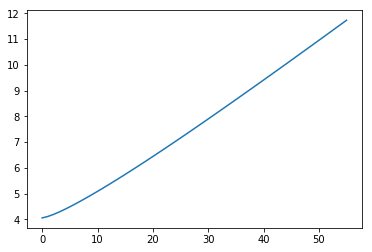

In [65]:
plt.plot(sing_val_log)

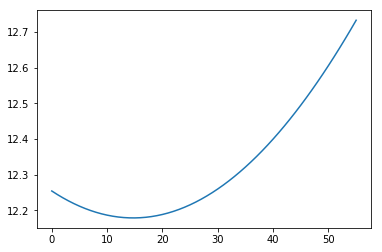

In [66]:
plt.plot(distances_log)